In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define las rutas
BASE_PATHS = {
    "fam-sim": "results/fam-sim/5_epochs/",
    "hc-100": "results/herarchical_cluster/dist_100/5_epochs/",
    "hc-200": "results/herarchical_cluster/dist_200/5_epochs/",
    "hc-400": "results/herarchical_cluster/dist_400/5_epochs/",
}

# 5 epochs

In [3]:
# Inicializa listas para acumular los dataframes
all_train_logs = []
all_test_results = []

# Recorre cada origen
for source, path in BASE_PATHS.items():
    if not os.path.exists(path):
        print(f"[WARN] Ruta no encontrada: {path}")
        continue

    for fam in os.listdir(path):
        fam_path = os.path.join(path, fam)
        train_csv = os.path.join(fam_path, "train_log.csv")
        test_csv = os.path.join(fam_path, "test_5e.csv")

        if os.path.isfile(train_csv):
            df_train = pd.read_csv(train_csv)
            df_train["fam"] = fam
            df_train["source"] = source
            all_train_logs.append(df_train)
        else:
            print(f"[WARN] No se encontró train_log.csv en {fam_path}")

        if os.path.isfile(test_csv):
            df_test = pd.read_csv(test_csv)
            df_test["fam"] = fam
            df_test["source"] = source
            all_test_results.append(df_test)
        else:
            print(f"[WARN] No se encontró test_5e.csv en {fam_path}")

In [4]:
# Combina todos los resultados en un solo DataFrame
train_logs_df = pd.concat(all_train_logs, ignore_index=True)
test_results_df = pd.concat(all_test_results, ignore_index=True)

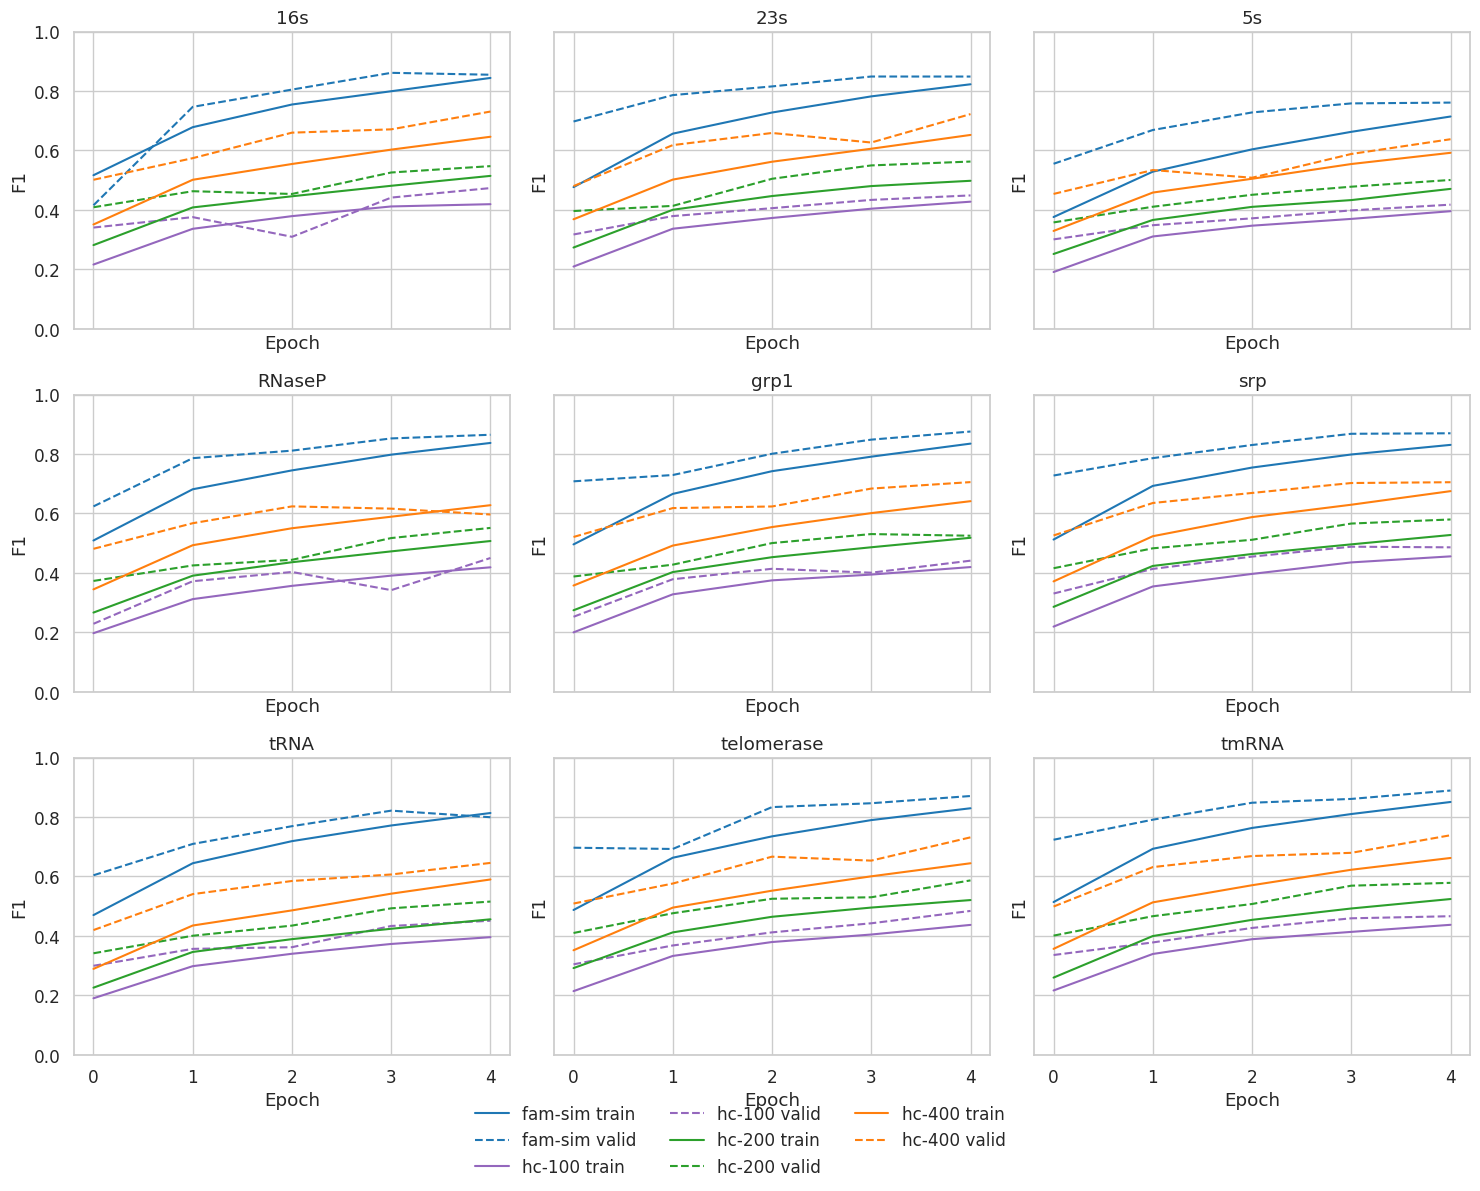

In [5]:
# Estilo
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Métrica a graficar
metric = "f1"


train_logs2 = train_logs_df.copy()
train_logs2["valid_f1"] = train_logs2["valid_f1_post"]

# Reformatea el dataframe
df_long = pd.melt(
    train_logs2,
    id_vars=["fam", "source", "epoch"],
    value_vars=[f"train_{metric}", f"valid_{metric}"],
    var_name="set",
    value_name=metric,
)
df_long["set"] = df_long["set"].str.replace(
    f"_{metric}", "", regex=False
)  # 'train' o 'valid'

# Ordena familias
families = sorted(df_long["fam"].unique())

# Layout de subfiguras
n_cols = 3
n_rows = -(-len(families) // n_cols)  # ceiling division

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=True, sharey=True
)
axes = axes.flatten()

# Paleta por fuente
color_map = {
    "fam-sim": "tab:blue",
    "hc-100": "tab:purple",
    "hc-200": "tab:green",
    "hc-400": "tab:orange",
}

# Línea por tipo
linestyle_map = {
    "train": "-",
    "valid": "--",
}

# Dibuja cada subfigura
for ax, fam in zip(axes, families):
    df_fam = df_long[df_long["fam"] == fam]
    for (source, set_type), df_sub in df_fam.groupby(["source", "set"]):
        label = f"{source} {set_type}"
        ax.plot(
            df_sub["epoch"],
            df_sub[metric],
            label=label,
            color=color_map[source],
            linestyle=linestyle_map[set_type],
        )
    ax.set_title(fam)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric.capitalize())
    ax.set_ylim(0, 1)  # ajustar si es necesario

# Elimina ejes vacíos
for ax in axes[len(families) :]:
    ax.axis("off")

# Leyenda global
# Agrega solo una entrada por combinación (source, set)
handles, labels = axes[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # elimina duplicados
fig.legend(
    by_label.values(), by_label.keys(), loc="lower center", ncol=3, frameon=False
)

# Ajustes finales
plt.tight_layout(rect=[0, 0.05, 1, 1])  # deja espacio para la leyenda abajo
plt.show()

In [6]:
# --- métrica a mostrar ---
metric = "f1"  # Cambiar por "loss", "f1", etc. según tu archivo test_5e.csv

# --- agregación por familia/fuente ---
# Si test_5e.csv tiene múltiples filas, agregamos (promedio por defecto)
summary = test_results_df.groupby(["fam", "source"])[metric].mean().reset_index()

# --- tabla pivot ---
pivot_table = summary.pivot(index="fam", columns="source", values=metric)

# Ordena columnas si querés
pivot_table = pivot_table[["fam-sim", "hc-100", "hc-200", "hc-400"]]
pivot_table

source,fam-sim,hc-100,hc-200,hc-400
fam,,,,
16s,0.362,0.336,0.326,0.363
23s,0.298,0.355,0.420,0.410
5s,0.411,0.504,0.524,0.495
RNaseP,0.403,0.398,0.371,0.340
grp1,0.347,0.305,0.383,0.388
srp,0.229,0.263,0.276,0.194
tRNA,0.628,0.587,0.644,0.637
telomerase,0.217,0.237,0.210,0.203
tmRNA,0.296,0.324,0.329,0.325


In [7]:
# --- métrica a mostrar ---
metric = "f1_post"  # Cambiar por "loss", "f1", etc. según tu archivo test_5e.csv

# --- agregación por familia/fuente ---
# Si test_5e.csv tiene múltiples filas, agregamos (promedio por defecto)
summary = test_results_df.groupby(["fam", "source"])[metric].mean().reset_index()

# --- tabla pivot ---
pivot_table = summary.pivot(index="fam", columns="source", values=metric)

# Ordena columnas si querés
pivot_table = pivot_table[["fam-sim", "hc-100", "hc-200", "hc-400"]]
pivot_table

source,fam-sim,hc-100,hc-200,hc-400
fam,,,,
16s,0.369,0.377,0.344,0.386
23s,0.298,0.403,0.430,0.435
5s,0.412,0.498,0.525,0.515
RNaseP,0.432,0.461,0.450,0.343
grp1,0.369,0.381,0.399,0.392
srp,0.225,0.261,0.278,0.193
tRNA,0.644,0.595,0.660,0.647
telomerase,0.196,0.227,0.187,0.187
tmRNA,0.331,0.343,0.361,0.347


<Axes: title={'center': 'Test | 5 epochs'}, ylabel='fam'>

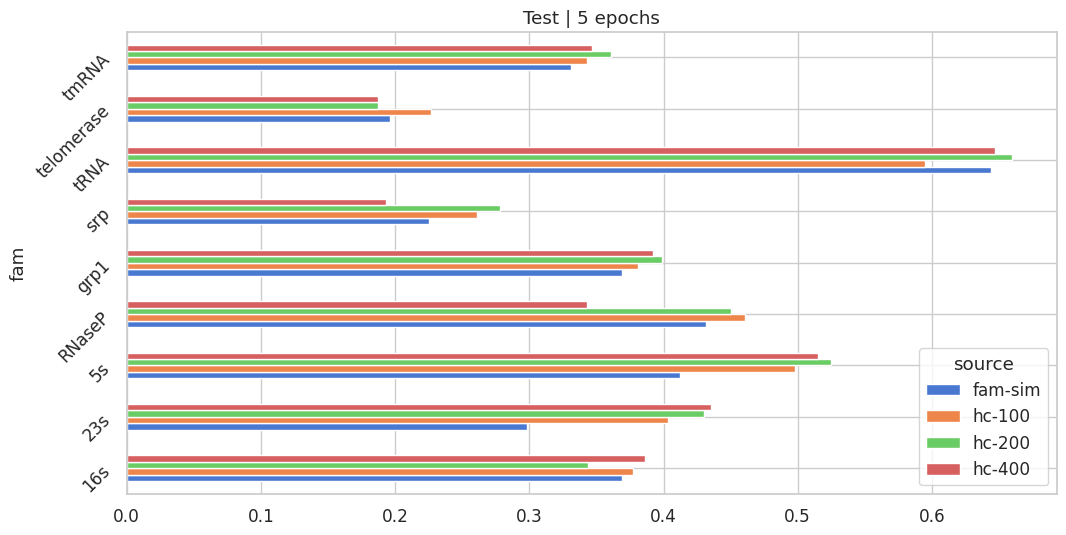

In [8]:
# Muestra la tabla
pivot_table.plot(
    kind="barh", figsize=(12, 6), rot=45, grid=True, title="Test | 5 epochs"
)

In [9]:
pivot_table.to_csv('results/hc_5e_f1_post_test.csv')

# 10 epochs

In [10]:
# Define las rutas
BASE_PATHS = {
    "fam-sim": "results/fam-sim/10_epochs/",
    "hc-100": "results/herarchical_cluster/dist_100/10_epochs/",
    "hc-200": "results/herarchical_cluster/dist_200/10_epochs/",
    "hc-400": "results/herarchical_cluster/dist_400/10_epochs/",
}

In [11]:
# Inicializa listas para acumular los dataframes
all_train_logs_10 = []
all_test_results_10 = []

# Recorre cada origen
for source, path in BASE_PATHS.items():
    if not os.path.exists(path):
        print(f"[WARN] Ruta no encontrada: {path}")
        continue

    for fam in os.listdir(path):
        fam_path = os.path.join(path, fam)
        train_csv = os.path.join(fam_path, "train_log.csv")
        test_csv = os.path.join(fam_path, "test_10e.csv")

        if os.path.isfile(train_csv):
            df_train = pd.read_csv(train_csv)
            df_train["fam"] = fam
            df_train["source"] = source
            all_train_logs_10.append(df_train)
        else:
            print(f"[WARN] No se encontró train_log.csv en {fam_path}")

        if os.path.isfile(test_csv):
            df_test = pd.read_csv(test_csv)
            df_test["fam"] = fam
            df_test["source"] = source
            all_test_results_10.append(df_test)
        else:
            print(f"[WARN] No se encontró test_1e.csv en {fam_path}")

In [12]:
# Combina todos los resultados en un solo DataFrame
train_logs_df_10 = pd.concat(all_train_logs_10, ignore_index=True)
test_results_df_10 = pd.concat(all_test_results_10, ignore_index=True)
train_logs_df_10["epoch"] += 5
all_train_logs = pd.concat([train_logs_df, train_logs_df_10], ignore_index=True)

In [13]:
train_logs_df

,epoch,train_f1,train_loss,valid_f1,valid_f1_post,valid_loss,fam,source
0,0,0.4766,0.0407,0.6247,0.6974,0.0254,23s,fam-sim
1,1,0.6565,0.0212,0.7742,0.7862,0.0217,23s,fam-sim
2,2,0.7276,0.0159,0.7307,0.8154,0.0142,23s,fam-sim
3,3,0.7819,0.0122,0.8006,0.8487,0.0130,23s,fam-sim
4,4,0.8226,0.0092,0.8427,0.8486,0.0184,23s,fam-sim
...,...,...,...,...,...,...,...,...
175,0,0.2892,0.0487,0.3618,0.4197,0.0389,tRNA,hc-400
176,1,0.4350,0.0279,0.5156,0.5406,0.0315,tRNA,hc-400
177,2,0.4859,0.0249,0.5560,0.5848,0.0296,tRNA,hc-400
178,3,0.5421,0.0212,0.5922,0.6067,0.0309,tRNA,hc-400


<Axes: title={'center': 'Test | 10 epochs'}, ylabel='fam'>

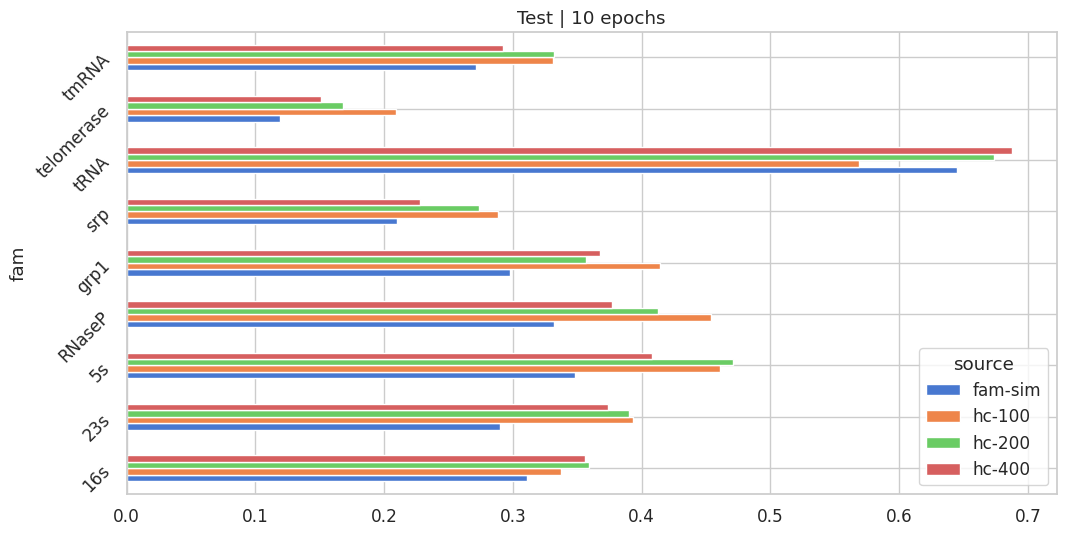

In [14]:
# --- métrica a mostrar ---
metric = "f1_post"  # Cambiar por "loss", "f1", etc. según tu archivo test_5e.csv

# --- agregación por familia/fuente ---
# Si test_5e.csv tiene múltiples filas, agregamos (promedio por defecto)
summary = test_results_df_10.groupby(["fam", "source"])[metric].mean().reset_index()

# --- tabla pivot ---
pivot_table = summary.pivot(index="fam", columns="source", values=metric)

# Ordena columnas si querés
pivot_table = pivot_table[["fam-sim", "hc-100", "hc-200", "hc-400"]]

# Muestra la tabla
pivot_table.plot(
    kind="barh", figsize=(12, 6), rot=45, grid=True, title="Test | 10 epochs"
)

In [15]:
pivot_table.to_csv('results/hc_10e_f1_post_test.csv')

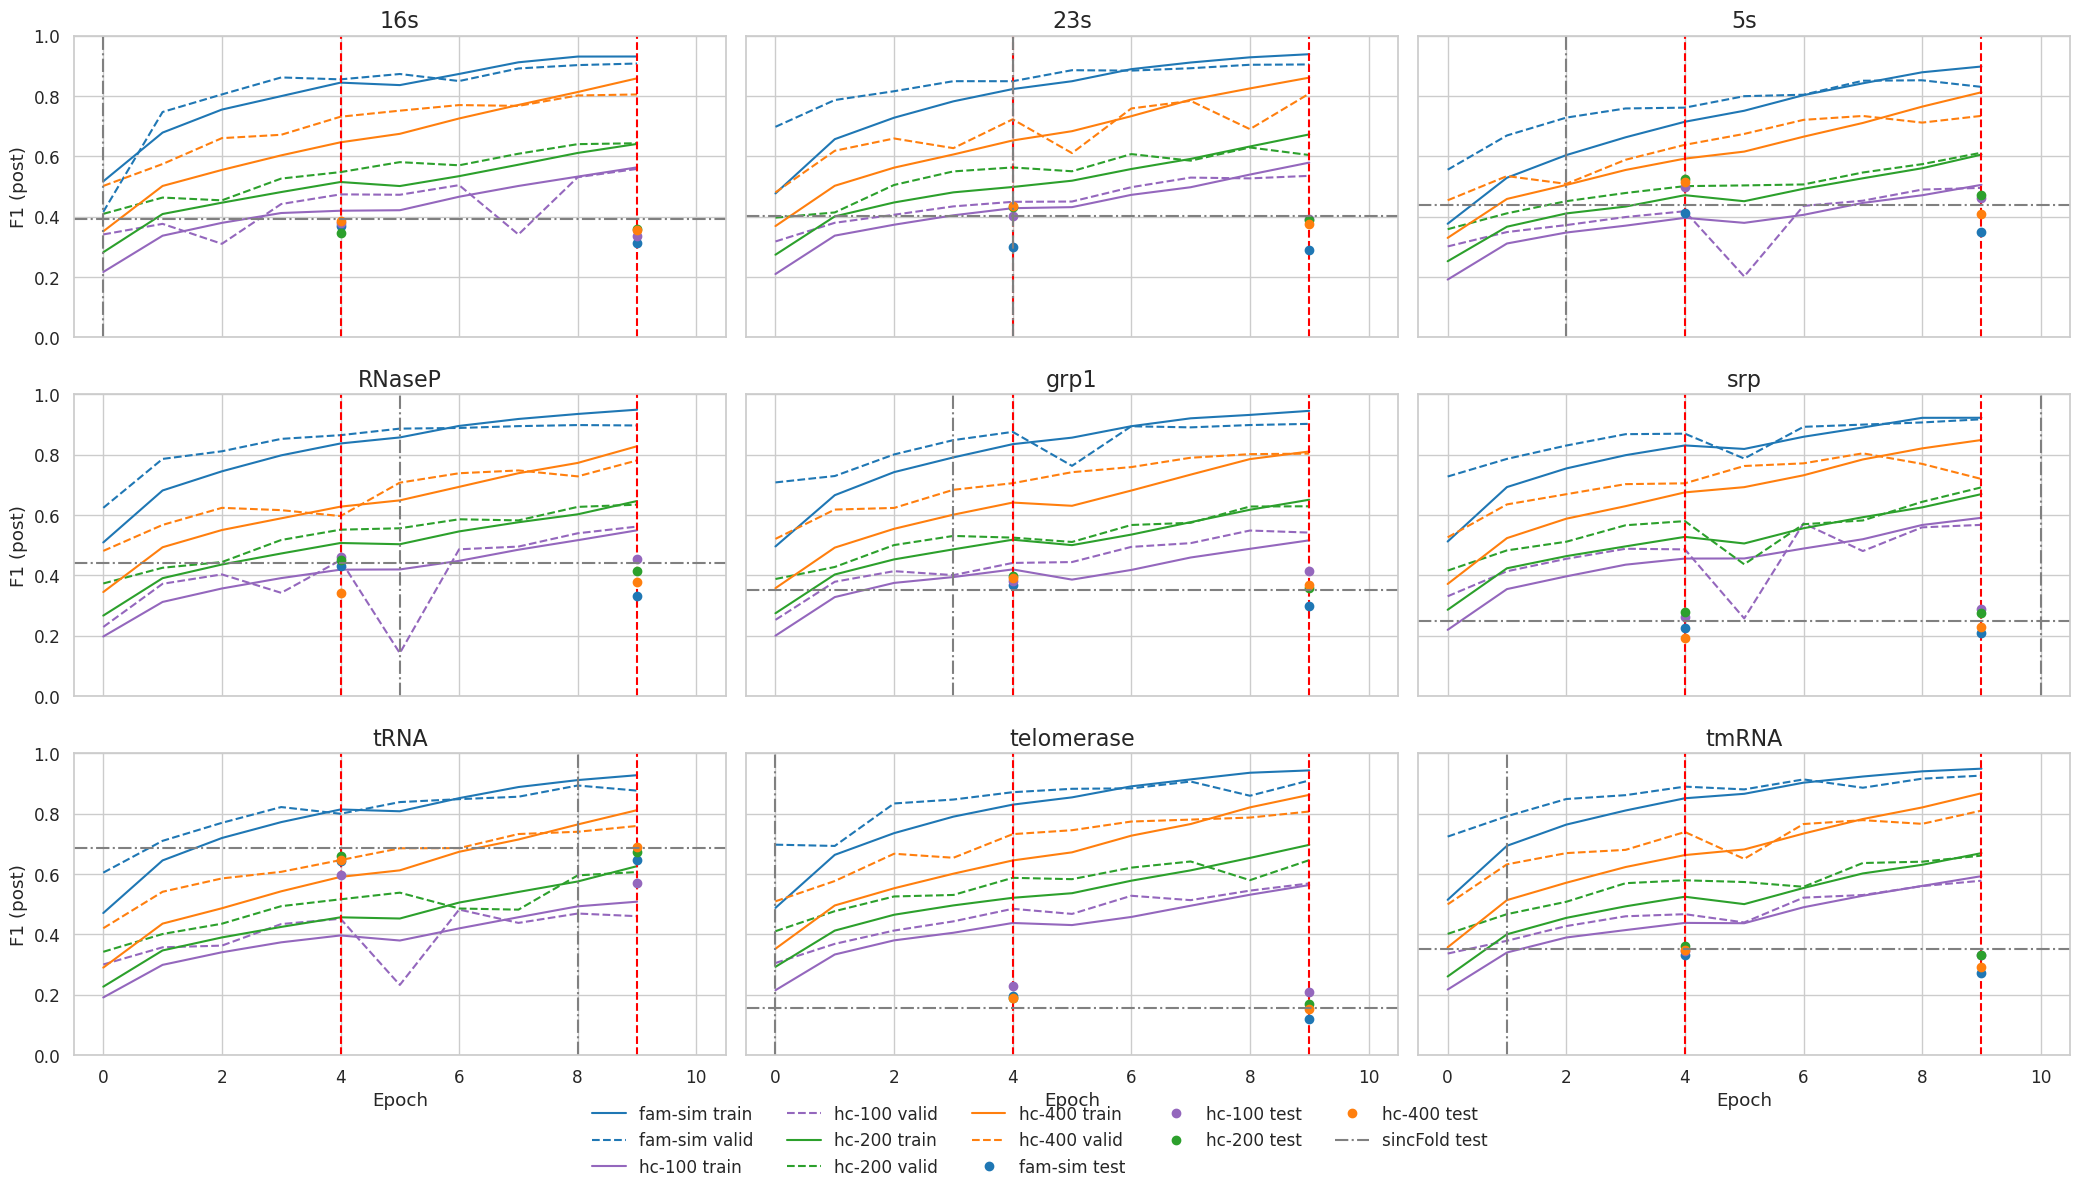

In [16]:
# --- Configuración general ---
sns.set(style="whitegrid", palette="muted", font_scale=1.1)
metric = "f1"
metric_test = "f1_post"

# --- Prepara datos de entrenamiento ---
train_logs2 = all_train_logs.copy()
train_logs2["valid_f1"] = train_logs2["valid_f1_post"]

df_long = pd.melt(
    train_logs2,
    id_vars=["fam", "source", "epoch"],
    value_vars=[f"train_{metric}", f"valid_{metric}"],
    var_name="set",
    value_name=metric,
)
df_long["set"] = df_long["set"].str.replace(f"_{metric}", "", regex=False)


# --- Prepara resultados de test para epoch 4 y 9 ---
def build_pivot(df_test):
    summary = df_test.groupby(["fam", "source"])[metric_test].mean().reset_index()
    pivot = summary.pivot(index="fam", columns="source", values=metric_test)
    return pivot[["fam-sim", "hc-100", "hc-200", "hc-400"]]  # orden fijo


pivot_test_5 = build_pivot(test_results_df)  # para epoch=4
pivot_test_10 = build_pivot(test_results_df_10)  # para epoch=9

# --- F1 de sincFold (línea horizontal de referencia) ---
sincfold_f1 = {
    "16s": 0.391664,
    "23s": 0.402430,
    "5s": 0.438967,
    "RNaseP": 0.442618,
    "grp1": 0.349969,
    "srp": 0.249175,
    "tRNA": 0.685143,
    "telomerase": 0.154173,
    "tmRNA": 0.350146,
}

sincfold_best = {
    "16s": 0,
    "23s": 4,
    "5s": 2,
    "RNaseP": 5,
    "grp1": 3,
    "srp": 10,
    "tRNA": 8,
    "telomerase": 0,
    "tmRNA": 1,
}

# --- Configura colores y estilos ---
families = sorted(df_long["fam"].unique())
n_cols = 3
n_rows = -(-len(families) // n_cols)

color_map = {
    "fam-sim": "tab:blue",
    "hc-100": "tab:purple",
    "hc-200": "tab:green",
    "hc-400": "tab:orange",
}
linestyle_map = {
    "train": "-",
    "valid": "--",
}

# --- Figura y subplots ---
fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(n_cols * 7, n_rows * 4), sharex=True, sharey=True
)
axes = axes.flatten()

for ax, fam in zip(axes, families):
    df_fam = df_long[df_long["fam"] == fam]

    # Curvas de entrenamiento/validación
    for (source, set_type), df_sub in df_fam.groupby(["source", "set"]):
        label = f"{source} {set_type}"
        ax.plot(
            df_sub["epoch"],
            df_sub[metric],
            label=label,
            color=color_map[source],
            linestyle=linestyle_map[set_type],
        )

    # Líneas verticales
    ax.axvline(4, color="red", linestyle="--")
    ax.axvline(9, color="red", linestyle="--")

    # Punto test epoch=4
    for source in ["fam-sim", "hc-100", "hc-200", "hc-400"]:
        if source in pivot_test_5.columns:
            try:
                test_f1_5 = pivot_test_5.loc[fam, source]
                ax.plot(
                    4,
                    test_f1_5,
                    marker="o",
                    markersize=6,
                    color=color_map[source],
                    linestyle="none",
                    label=f"{source} test",
                )
            except KeyError:
                pass

    # Punto test epoch=9
    for source in ["fam-sim", "hc-100", "hc-200", "hc-400"]:
        if source in pivot_test_10.columns:
            try:
                test_f1_10 = pivot_test_10.loc[fam, source]
                ax.plot(
                    9,
                    test_f1_10,
                    marker="o",
                    markersize=6,
                    color=color_map[source],
                    linestyle="none",
                )
            except KeyError:
                pass

    # Línea horizontal de sincFold
    if fam in sincfold_f1:
        ax.axhline(
            sincfold_f1[fam], color="gray", linestyle="-.", label="sincFold test"
        )
    if fam in sincfold_best:
        ax.axvline(sincfold_best[fam], color="gray", linestyle="-.")

    ax.set_title(fam, fontsize=16)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("F1 (post)")
    ax.set_ylim(0, 1)

# Oculta subplots vacíos
for ax in axes[len(families) :]:
    ax.axis("off")

# Leyenda global
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles += h
    labels += l
by_label = dict(zip(labels, handles))
fig.legend(
    by_label.values(), by_label.keys(), loc="lower center", ncol=5, frameon=False
)

for i in range(6):
    axes[i].set_xlabel(None)
for i in [1, 2, 4, 5, 7, 8]:
    axes[i].set_ylabel(None)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()